Датасет був взятий з https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification/data

In [100]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/My Drive/NN/data'
val_path = '/content/drive/My Drive/NN/val_data'

In [ ]:
# !pip install kaggle

# !mkdir /.kaggle
# !mv kaggle.json /.kaggle
# !mv /.kaggle /root/
# !chmod 600 ~/.kaggle/kaggle.json

In [101]:
# !kaggle datasets download -d mahmoudreda55/satellite-image-classification

Dataset URL: https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification
License(s): copyright-authors
satellite-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [102]:
# !unzip satellite-image-classification.zip

Показано результат, скорочений до останніх рядків (5000).
  inflating: data/cloudy/train_23566.jpg  
  inflating: data/cloudy/train_23598.jpg  
  inflating: data/cloudy/train_23608.jpg  
  inflating: data/cloudy/train_23634.jpg  
  inflating: data/cloudy/train_23636.jpg  
  inflating: data/cloudy/train_23646.jpg  
  inflating: data/cloudy/train_2366.jpg  
  inflating: data/cloudy/train_23664.jpg  
  inflating: data/cloudy/train_23706.jpg  
  inflating: data/cloudy/train_2380.jpg  
  inflating: data/cloudy/train_23805.jpg  
  inflating: data/cloudy/train_23806.jpg  
  inflating: data/cloudy/train_23826.jpg  
  inflating: data/cloudy/train_23843.jpg  
  inflating: data/cloudy/train_23877.jpg  
  inflating: data/cloudy/train_23884.jpg  
  inflating: data/cloudy/train_23953.jpg  
  inflating: data/cloudy/train_2396.jpg  
  inflating: data/cloudy/train_23978.jpg  
  inflating: data/cloudy/train_23979.jpg  
  inflating: data/cloudy/train_23980.jpg  
  inflating: data/cloudy/train_23981.jpg  

In [104]:
path = '/content/data'
val_path = '/content/val_data'

## EDA

In [105]:
classes = os.listdir(path)
print(f"Кількість класів: {len(classes)}")
class_counts = {}

for cls in classes:
    cls_path = os.path.join(path, cls)
    num_images = len(os.listdir(cls_path))
    class_counts[cls] = num_images
    print(f"Клас '{cls}': {num_images} зображень")


Кількість класів: 4
Клас 'green_area': 1500 зображень
Клас 'water': 1500 зображень
Клас 'desert': 1131 зображень
Клас 'cloudy': 1500 зображень


Усього 5631 зображення у форматі '.jpg'.

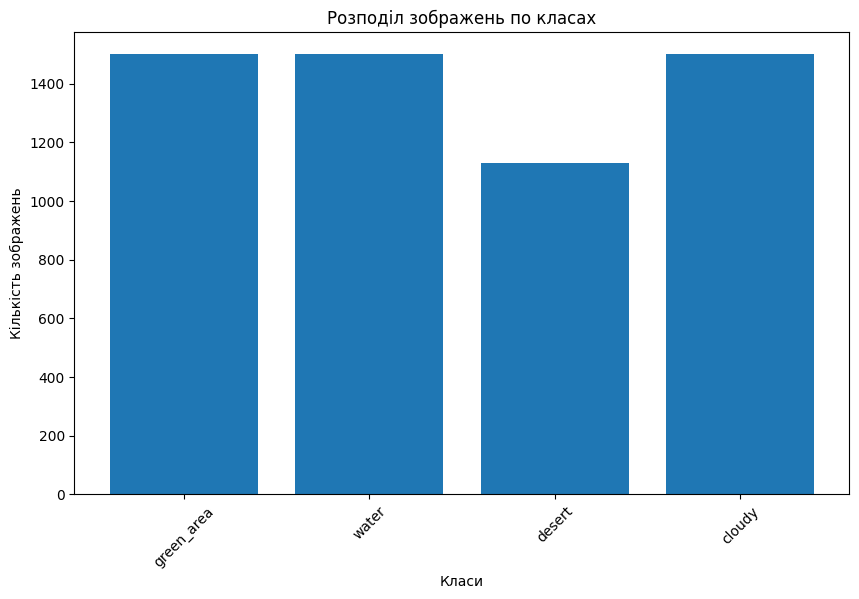

In [106]:
plt.figure(figsize=(10,6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Класи')
plt.ylabel('Кількість зображень')
plt.title('Розподіл зображень по класах')
plt.xticks(rotation=45)
plt.show()


Клас desert представлений меншою кількістю зображень порівняно з іншими класами. Це може вплинути на навчання моделі, оскільки модель може навчитися краще розпізнавати класи з більшою кількістю зображень, такі як water, cloudy, і green_area

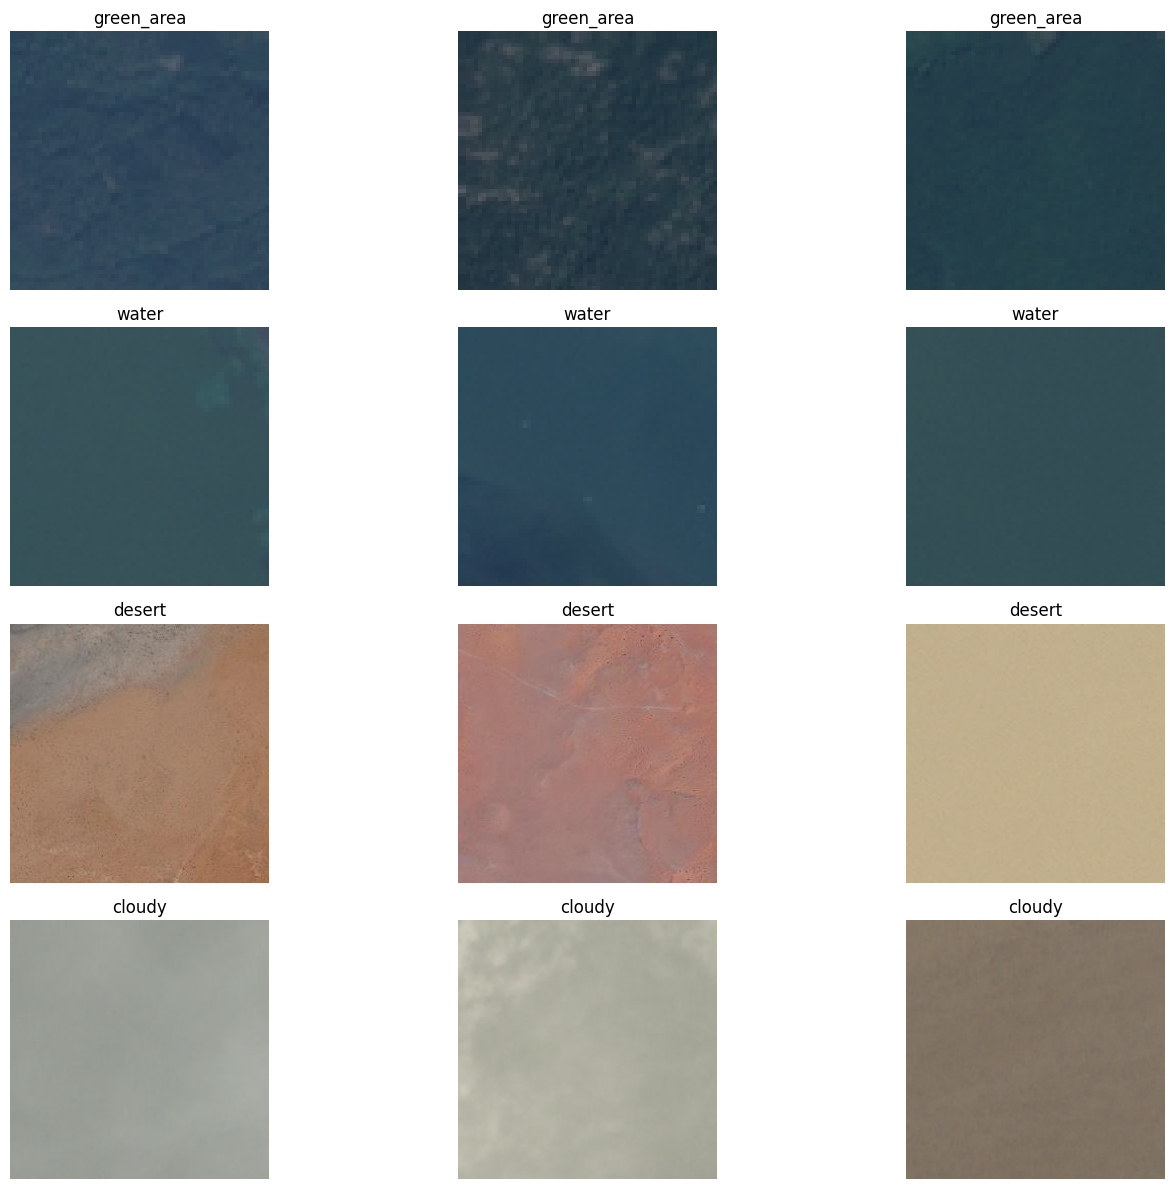

In [107]:
# Перегляд прикладів зображень з кожного класу
num_classes = len(classes)
plt.figure(figsize=(15, num_classes * 3))

for i, cls in enumerate(classes):
    cls_path = os.path.join(path, cls)
    images = os.listdir(cls_path)
    for j in range(3):  # Відобразимо 3 зображення з кожного класу
        img_path = os.path.join(cls_path, images[j])
        img = plt.imread(img_path)
        ax = plt.subplot(num_classes, 3, i * 3 + j + 1)
        plt.imshow(img)
        plt.title(f"{cls}")
        plt.axis("off")

plt.tight_layout()
plt.show()


In [108]:
# Перевірка розмірів зображень
from PIL import Image

image_shapes = []

for cls in classes:
    cls_path = os.path.join(path, cls)
    images = os.listdir(cls_path)
    for img_name in images[:100]:  # Перевіримо перші 100 зображень кожного класу
        img_path = os.path.join(cls_path, img_name)
        with Image.open(img_path) as img:
            image_shapes.append(img.size)

unique_shapes = set(image_shapes)
print(f"Унікальні розміри зображень: {unique_shapes}")


Унікальні розміри зображень: {(256, 256), (64, 64)}


Наявність зображень різних розмірів може бути проблемою для нейронної мережі, оскільки на вході моделі очікується, що всі зображення мають однаковий розмір. Розбіжність у розмірах вимагає попередньої обробки — всі зображення повинні бути приведені до одного розміру перед використанням у моделі.

In [109]:
# Розподілимо на трейнінг і валідейшн сети
train = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="training",
    seed=1234)

val = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=1234)


Found 5631 files belonging to 4 classes.
Using 4505 files for training.
Found 5631 files belonging to 4 classes.
Using 1126 files for validation.


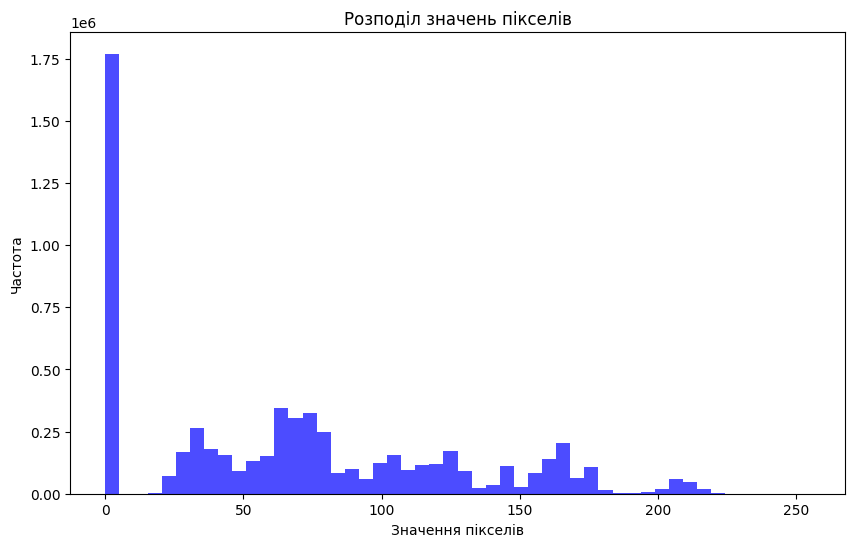

In [110]:
# Аналіз значень пікселів
import numpy as np

pixel_values = []

for images, labels in train.take(1):
    images = images.numpy()
    pixel_values.extend(images.flatten())

pixel_values = np.array(pixel_values)
plt.figure(figsize=(10,6))
plt.hist(pixel_values, bins=50, color='blue', alpha=0.7)
plt.xlabel('Значення пікселів')
plt.ylabel('Частота')
plt.title('Розподіл значень пікселів')
plt.show()


Вершина на позначці 0 свідчить про те, що значна кількість пікселів у зображеннях має значення 0, що вказує на великі ділянки чорного або порожні області в зображеннях.

Інші значення пікселів розподілені в різних діапазонах з деякими піками в межах 50, 100, 150, і 200. Це типовий розподіл для зображень в градаціях сірого або кольорових зображень у форматі RGB.

Щоб полегшити навчання нейронної мережі, варто нормалізувати значення пікселів. Нормалізація пікселів в діапазон [0, 1] допоможе нейромережі швидше і ефективніше навчатися.

In [111]:
# Чи є дублікати?
import hashlib

hashes = set()
duplicates = []

for cls in classes:
    cls_path = os.path.join(path, cls)
    images = os.listdir(cls_path)
    for img_name in images:
        img_path = os.path.join(cls_path, img_name)
        with open(img_path, 'rb') as f:
            img_hash = hashlib.md5(f.read()).hexdigest()
            if img_hash in hashes:
                duplicates.append(img_path)
            else:
                hashes.add(img_hash)

print(f"Знайдено {len(duplicates)} дублікати зображень.")


Знайдено 39 дублікати зображень.


Дублікати треба видалити.

In [113]:
# Підрахунок кількості зображень у кожному класі в тренувальному наборі
train_class_counts = {}

for images, labels in train:
    labels = labels.numpy()
    for label in labels:
        class_name = train.class_names[label]
        if class_name in train_class_counts:
            train_class_counts[class_name] += 1
        else:
            train_class_counts[class_name] = 1

# Підрахунок кількості зображень у кожному класі у валідаційному наборі
val_class_counts = {}

for images, labels in val:
    labels = labels.numpy()
    for label in labels:
        class_name = val.class_names[label]
        if class_name in val_class_counts:
            val_class_counts[class_name] += 1
        else:
            val_class_counts[class_name] = 1

print("Розподіл класів у тренувальному наборі:")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count} зображень")

print("\nРозподіл класів у валідаційному наборі:")
for class_name, count in val_class_counts.items():
    print(f"{class_name}: {count} зображень")


Розподіл класів у тренувальному наборі:
cloudy: 1205 зображень
green_area: 1192 зображень
desert: 908 зображень
water: 1200 зображень

Розподіл класів у валідаційному наборі:
water: 300 зображень
cloudy: 295 зображень
green_area: 308 зображень
desert: 223 зображень


Набір даних в цілому добре збалансований, за винятком класу desert, який має менше зображень.

## Preprocessing

Розробити функції для препроцесингу датасету, навести аргументацію щодо застосування тих чи інших функцій препроцесингу.



Основні необхідні частини попередньої обробки, виявлені під час EDA:

*   Видалити дуплікати;
*   Зображення повинні бути приведені до одного розміру;
*   Варто нормалізувати значення пікселі в діапазоні [0; 1];




In [114]:
import torchvision.datasets as datasets
import torch
from torchvision import transforms

import os
import shutil
import random

In [115]:
def compute_image_hash(image):
    return hashlib.md5(image.tobytes()).hexdigest()

def remove_duplicates(dataset_path):
    image_hashes = set()
    unique_images = []

    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('jpg'):
                image_path = os.path.join(root, file)
                image = Image.open(image_path)
                image_hash = compute_image_hash(image)

                if image_hash not in image_hashes:
                    image_hashes.add(image_hash)
                    unique_images.append(image_path)
                else:
                    os.remove(image_path)
                    print(f"Duplicate removed: {image_path}")

    return unique_images

print(f'Now there are {len(remove_duplicates(path))} unique pictures left in the data.')

Duplicate removed: /content/data/desert/desert(786).jpg
Duplicate removed: /content/data/desert/desert(748) (1).jpg
Duplicate removed: /content/data/desert/desert(643).jpg
Duplicate removed: /content/data/desert/desert(749).jpg
Duplicate removed: /content/data/desert/desert(637).jpg
Duplicate removed: /content/data/desert/desert(783) (1).jpg
Duplicate removed: /content/data/desert/desert(331) (1).jpg
Duplicate removed: /content/data/desert/desert(413) (1).jpg
Duplicate removed: /content/data/desert/desert(1008).jpg
Duplicate removed: /content/data/desert/desert(335) (1).jpg
Duplicate removed: /content/data/desert/desert(334).jpg
Duplicate removed: /content/data/desert/desert(787) (1).jpg
Duplicate removed: /content/data/desert/desert(64) (1).jpg
Duplicate removed: /content/data/desert/desert(639) (1).jpg
Duplicate removed: /content/data/desert/desert(332) (1).jpg
Duplicate removed: /content/data/desert/desert(747) (1).jpg
Duplicate removed: /content/data/desert/desert(745) (1).jpg
Dupl

In [116]:
def split_dataset_into_train_val(root_dir, val_dir, split_ratio=0.2):
    # Make sure the validation directory exists
    if not os.path.exists(val_dir):
        os.makedirs(val_dir)

    # Loop through each subdirectory (class folder) in the root directory
    for subdir in os.listdir(root_dir):
        subdir_path = os.path.join(root_dir, subdir)

        # Only process directories (subfolders)
        if os.path.isdir(subdir_path):
            # Get list of all image files in the folder
            images = [f for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))]

            # Randomly select 20% of the images
            val_size = int(len(images) * split_ratio)
            val_images = random.sample(images, val_size)

            # Create corresponding validation subdirectory
            val_subdir = os.path.join(val_dir, subdir)
            if not os.path.exists(val_subdir):
                os.makedirs(val_subdir)

            # Move the selected images to the validation subdirectory
            for img in val_images:
                img_path = os.path.join(subdir_path, img)
                shutil.move(img_path, os.path.join(val_subdir, img))

            print(f"Moved {val_size} images from {subdir} to {val_subdir}")

# Split dataset and move 20% of images to the validation folder
split_dataset_into_train_val(path, val_path, split_ratio=0.2)


Moved 300 images from green_area to /content/val_data/green_area
Moved 300 images from water to /content/val_data/water
Moved 218 images from desert to /content/val_data/desert
Moved 300 images from cloudy to /content/val_data/cloudy


In [117]:
pre_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))
])

train_dataset0 = datasets.ImageFolder(path, transform=pre_transform)
val_dataset0 = datasets.ImageFolder(val_path, transform=pre_transform)

In [118]:
def get_mean_std(loader):
    mean = 0.0
    std = 0.0
    total_images = 0

    for images, _ in loader:
        batch_size = images.size(0)
        images = images.view(batch_size, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_size

    mean /= total_images
    std /= total_images

    return mean, std

batch_size = 32
train_loader0 = torch.utils.data.DataLoader(train_dataset0, batch_size=batch_size, shuffle=True)
val_loader0 = torch.utils.data.DataLoader(val_dataset0, batch_size=batch_size, shuffle=True)

tmean, tstd = get_mean_std(train_loader0)
vmean, vstd = get_mean_std(val_loader0)

print(f"For training set: Mean: {tmean}, Std: {tstd}")
print(f"For validation set: Mean: {vmean}, Std: {vstd}")

For training set: Mean: tensor([0.3985, 0.4306, 0.4271]), Std: tensor([0.0222, 0.0199, 0.0181])
For validation set: Mean: tensor([0.3971, 0.4291, 0.4256]), Std: tensor([0.0227, 0.0204, 0.0184])


In [119]:
train_transform = transforms.Compose([
    transforms.ToTensor(),

    transforms.Normalize(tmean, tstd),
    transforms.Resize((256, 256)),

    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
    transforms.RandomAffine(degrees=0, shear=0.2),

    transforms.GaussianBlur((3, 3))
])

val_transform = transforms.Compose([
    transforms.ToTensor(),

    transforms.Normalize(vmean, vstd),
    transforms.Resize((256, 256)),

    transforms.GaussianBlur((3, 3))
])

train_dataset = datasets.ImageFolder(root=path, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = datasets.ImageFolder(root=val_path, transform=val_transform)
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=False)

**Опис та аргументація змін:**

*   Видалення копій -> Для очищення даних, відсутності повторів. Адже спочатку в даних було 39 дублікатів.
*   Зміна розміру усіх зображень до (256, 256) -> Стандартизація для постійності даних, відсутності проблем з тензорами різного розміру під час навчання. Адже дані початково були двох різних розмірів (256, 256) та (64, 64).
*   Нормалізація в діапазоні [0; 1] -> Зменшення різниці в яскравості та контрасті між зображеннями, прибираються outliers піксель, модель швидше та краще навчається.
*   Перетворення на тензор та зміна до (C, H, W) -> Частина підготовки даних до роботи з PyTorch.
*   Gaussian Blur (Розмиття по Гаусу) -> Прибирання легкого шуму на фотографіях, що міг виникнути від коливань в атмосфері/погодних умов (супутникові знімки). Щоб зробити картинку більш плавною, зменшити шум, мінімально зачіпаючи деталі.
*   У тренувальному сеті різні додаткові зміни/трансформації, такі як випадкові повороти, зміна на горизонтальний вигляд, збільшення та обрізання, нахили -> Зробити тренувальний датасет більш різноманітним, зменшити шанс overfitting.



---


> *Примітки:*
1.  Окремі трансформатори для тренувального та валідаційного сетів, адже хотіли додати більше різноманіття в тренувальний сет, але при цьому залишити валідаційний сет постійним.
2.  Не використовували техніки з підвищення контрасту, адже пікселі даних зображень і так мають достатньо різні значення.

